# Problem Set 7: Facial Recognition
<span style="color:red">WARNING:</span> Some of the problems in this problem set require heavy computation - you are encouraged to start early so that you don't get stuck at the last minute.

# Face Recognition

Your goal for this problem set is to design a basic face recognition system. Since the machine learning force is now strong with you, the prompts for this problem set are deliberately vague. Be creative - but be careful!

One suggestion: Start by implementing this entire problem set on a relatively small subset of all of the images first, before using the full dataset.

## 1. Data Exploration

Download the "[Faces in the Wild](http://vis-www.cs.umass.edu/lfw/)" data set from [this link](http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz) (roughly 250MB).

### 1.1. Filter out people with few images

Display a histogram that shows the number of images per individual (you may use log-scale if you like). Which individual has the most images? Throw away all people for whom you have fewer than 10 images.

In [2]:
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

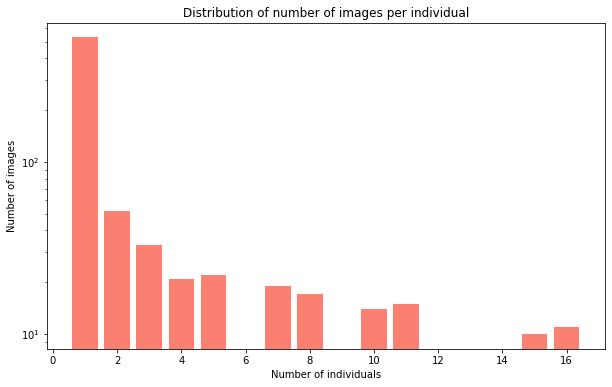

In [3]:
# Open a file
path = "lfw_funneled/"
dirs = os.listdir(path)

# Iterate each folder named after a person
over10 = []
for person in dirs:
    if person == '.DS_Store': # skip hidden file
        continue
        
    num = len([img for img in os.listdir("lfw_funneled/"+person)]) # count number of images in folder
    if num >= 10:
        over10.append([person, num]) # collect individuals with at least 10 images

over10_df = pd.DataFrame(over10, columns=['Name', 'Number of Images']) # convert to dataframe

# Plot histogram of number of images per individual; x-axis is count of individuals
plt.figure(figsize=(10,6))
num_img = over10_df['Number of Images'].value_counts().index
num_indiv = over10_df['Number of Images'].value_counts().values
plt.bar(x=num_indiv, height=num_img, log=True, color='salmon') # log-scale for num of images
plt.xlabel('Number of individuals')
plt.ylabel('Number of images')
plt.title('Distribution of number of images per individual')
plt.show()

In [4]:
# Who has the most images
print('The person who has the most images is shown below:')
display(over10_df[over10_df['Number of Images']==max(over10_df['Number of Images'])])

The person who has the most images is shown below:


,Name,Number of Images
136,George_W_Bush,530


### 1.2. Show some faces!

1. Pick 8 random images from the dataset and display them in a 2 x 4 grid.
2. Create a single image that shows the "average face" (acros the entire dataset, not just the 8 random ones) -- i.e., each pixel should display the average value of that pixel across all of the images. 
3. For each pixel, calculate the standard deviation of values for that pixel (you will have a different standard deviation for each of the three color channels, feel free to just show the standard deviation of one of the channels, or to average the standard deviation of the three channels at each pixel). Plot these standard deviations as a heatmap.

What do you notice about the distribution of mean and standard deviation values in these images? (e.g., are they evenly distributed)

In [5]:
import matplotlib.image as mpimg
from PIL import Image
import random

We randomly pick 8 images:
 ['Tim_Henman_0004.jpg', 'Julie_Gerberding_0004.jpg', 'Vicente_Fox_0009.jpg', 'Dominique_de_Villepin_0010.jpg', 'Tommy_Thompson_0008.jpg', 'Jiang_Zemin_0005.jpg', 'Jiri_Novak_0002.jpg', 'Charles_Moose_0002.jpg']


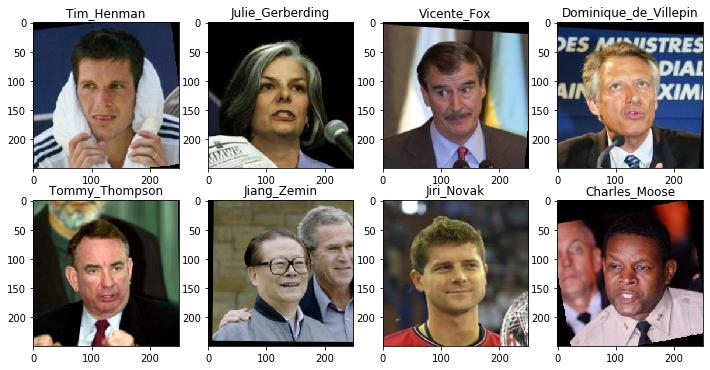

In [6]:
## 1. Show 8 random faces
# Create a dictionary to store image names for individuals that have at least 10 images
# key is Name, value is list of image names
all_imgs = {}
for person in over10_df['Name']:
    all_imgs[person] = [img for img in os.listdir("lfw_funneled/"+person)]

# Pick 8 random images from the dataset
random8 = list(over10_df.sample(n=8, random_state=42)['Name']) # 8 random people
imgs8 = [random.choice(all_imgs[person]) for person in random8] # 8 random images
print('We randomly pick 8 images:\n', imgs8)

# Display in a 2 x 4 grid
_, axs = plt.subplots(2, 4, figsize=(12, 6))
axs = axs.flatten()  

for img, ax, person in zip(imgs8, axs, random8):
    image = Image.open('lfw_funneled/'+person+'/'+img)
    ax.title.set_text(person)
    ax.imshow(image)

plt.show()

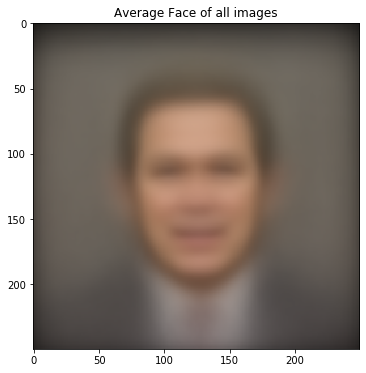

In [7]:
## 2. Show average face
# Convert image data to numpy array
all_data = []

for key, value in all_imgs.items():
    for img in value:
        image = Image.open('lfw_funneled/'+key+'/'+img) # read images from folders
        data = np.array(image) # convert to array shape of (250,250,3)
        all_data.append(data) # append data to list
        
all_data = np.array(all_data[1:]) # convert list to array

# Check the shape (# of imgs,250,250,3)
# all_data.shape

# Calculate average face data
avg_face_data = np.mean(all_data, axis=0)
# Convert from array to image
avg_face_img = Image.fromarray(avg_face_data.astype(np.uint8)) # convert float to dtype of uint8 so that PIL can read
avg_face_img.save('Average face of all images', 'JPEG') # svae image

# Show image
plt.figure(figsize=(6,6))
plt.title('Average Face of all images')
plt.imshow(avg_face_img)

In [8]:
## 3. Calculate standard deviation of pixels
import seaborn as sns

all_data_std = np.std(all_data, axis=0)

R = all_data_std[:,:,0]
G = all_data_std[:,:,1]
B = all_data_std[:,:,2]

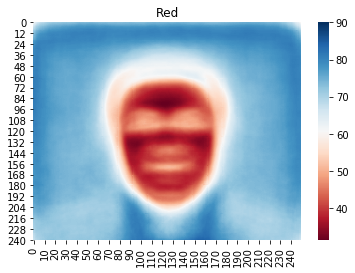

In [9]:
# Plot heatmap of std of values in Red
plt.figure(figsize=(6,4))
sns.heatmap(data=R, cmap='RdBu')
plt.title('Red')
plt.show()

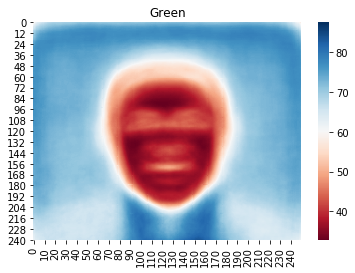

In [10]:
# Plot heatmap of std of values in Green
plt.figure(figsize=(6,4))
sns.heatmap(data=G, cmap='RdBu')
plt.title('Green')
plt.show()

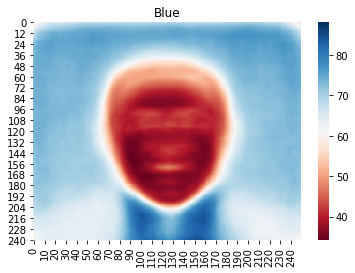

In [11]:
# Plot heatmap of std of values in Blue
plt.figure(figsize=(6,4))
sns.heatmap(data=B, cmap='RdBu')
plt.title('Blue')
plt.show()

The mean (average face) looks very much like a white male wearing a tie, and reminds me of George W Bush, since we know he has 503 images in the database, almost 10%, so it is not surprising the average face looks like him. 

The standard deviation are not evenly distributed for R, G and B. The face has relatively smaller std, and other parts of the image have higher std.

## 2. k-Means Clustering


### 2.1. Implementation

Implement the k-Means clustering algorithm that we discuseed in class, using the Euclidean distance function. This will require that you define three new functions:
1. InitializeCentroids(X, k)
2. FindClosestCentroids(X, centroids)
3. ComputeCentroidMeans(X, centroids, k)

*Hint:* You may find  the [`pairwise_distances_argmin`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise_distances_argmin.html) function useful.

In [12]:
# from sklearn.metrics import pairwise_distances_argmin

def ClusterKM(X, k):
    # Randomly choose clusters
    centroids = InitializeCentroids(X,k)
    
    while True:
        # Assign labels based on closest center
        idx = FindClosestCentroids(X, centroids)
        new_centroids = ComputeCentroidMeans(X, idx, k)

        # Check for convergence
        if np.all(centroids == new_centroids):
            break
        centroids = new_centroids
    
    return centroids, idx

In [13]:
def InitializeCentroids(X,k):
    # randomly choose k points as initial centroids
    idx = random.sample(range(X.shape[0]), k)
    
    centroids = []
    
    for i in idx:
        centroids.append(X[i])
        
    return np.array(centroids)

In [14]:
def FindClosestCentroids(X, centroids):
    
    k = centroids.shape[0]
    m = X.shape[0]
    
    idx = np.zeros((m, 1))
    temp = np.zeros((k,1))
    
    for i in range(m):
        for j in range(k):
            dist = np.sum((X[i,:] - centroids[j,:])**2)
            temp[j] = dist
            
        # find the index with the min distance
        idx[i] = np.argmin(temp)
    
    return idx

In [15]:
def ComputeCentroidMeans(X, idx, k):
    
    m, n = X.shape
    centroids = np.zeros((k,n))
    count = np.zeros((k,1))
    
    for i in range(m):
        index = int(idx[i][0])
        centroids[index,:] += X[i,:]
        count[index] += 1

    new_centroids = centroids/count
    
    return new_centroids

### 2.2. Sanity check

Apply your k-Means algorithm to a toy dataset to make sure it works properly. 

/Users/qyinhelena/anaconda3/envs/APIs_geospatial/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


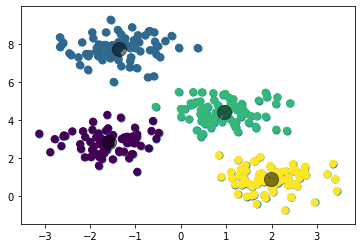

In [16]:
# does everything work as expected? Yes!

from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=50);

myCenters, myIdx = ClusterKM(X, 4)

plt.scatter(X[:, 0], X[:, 1], c=myIdx.reshape(myIdx.shape[0]), s=50, cmap='viridis')
plt.scatter(myCenters[:, 0], myCenters[:, 1], c='black', s=200, alpha=0.5);

### 2.3. Image centroids
Apply your k-Means algorithm to the images dataset, using k=20. Make sure to normalize your data first! Show a 20 x 2 grid of images where the first column contains (a) the image that represents the centroid for each of those clusters, and the second column contains (b) the closest image in the original dataset to that centroid. Use Euclidean distance. What do you notice?

*Note:* As you may notice, there are 250*250*3 = 187500 features for each image. If your k-Means algorithm is not implemented efficiently -- an even if it is! -- it might take a long time for your algorithm to converge. If your computer is old, it might even take a very long time for you to simply normalize your data. If you are running into such problems, you may convert your RGB images into greyscale first (using, for instance, the [`rgb2grey`](http://scikit-image.org/docs/dev/api/skimage.color.html#skimage.color.rgb2grey) function).



In [17]:
import sklearn
from skimage.color import rgb2gray

# Convert data to greyscale
gr_all_data = rgb2gray(all_data)

# Normalize all data; remember to vecorize dataset first
norm_all_data, norm = sklearn.preprocessing.normalize(gr_all_data.reshape(gr_all_data.shape[0],-1), axis=1, copy=True, return_norm=True)

# Apply K-Means algorithm, where k=20
face_centroids, face_Idx = ClusterKM(X=norm_all_data, k=20)

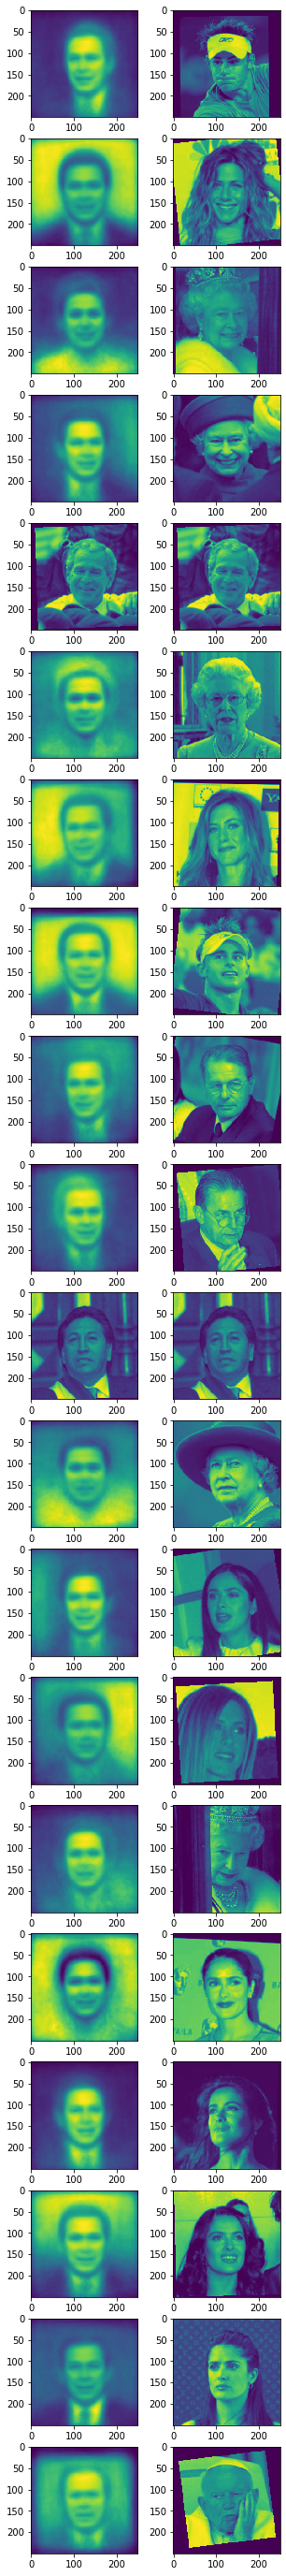

In [53]:
# Build a list of centroids images
cents = []
for data in face_centroids:
    img = data.reshape(250,250)
    cents.append(img)

# Build a dictionary for clusters, key as cluster label, value as imgs
clusters = {}
for i in range(len(cents)):
    idx = np.where(face_Idx==i)[0]
    clusters[i] = norm_all_data[idx]

# Find the closest image in each cluster to the respective centroid
closest = []
for i in range(len(cents)):
    dist = np.sum((clusters[i].reshape(clusters[i].shape[0],250,250) - cents[i])**2)
    closest_idx = np.argmin(dist)
    closest.append(clusters[i][closest_idx].reshape(250,250))
    
# Display in a 20 x 2 grid; 
# Left column is image of centroid in each of 20 clusters, right column is image of closest image to the centroid
_, axs = plt.subplots(20,2, figsize=(5,50)) 

for i in range(20):
    axs[i,0].imshow(cents[i])
    axs[i,1].imshow(closest[i])

plt.show()

I notice that centroid image is usually a non-existing face in the database, which is an average face of that cluster of images; still, there are two clusters using an existing face in the database as centroid, so the closest image on the right is the image itself. For those having an average face as centroid, I actually don't feel that much similarity between left and right. Or maybe the variation is pretty large so we gotta improve the k-means algorithm.

### 2.4 Classify yourself

Take a picture of yourself and scale it so that it is in a similar format to the images in the dataset. Show four images:
 1. The image of yourself
 2. The cluster centroid closest to that image
 3. The closest image in the original dataset to that cluster centroid
 4. The closest image in the original dataset to the image of yourself


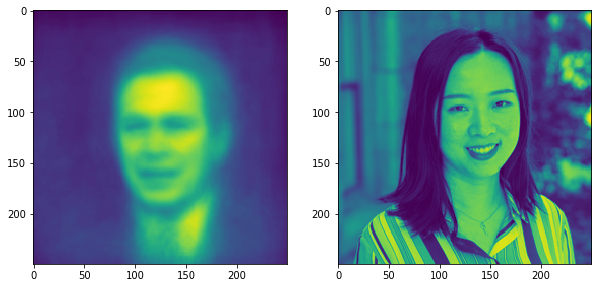

In [74]:
# 1. Import my photo
# resize to (250,250), convert to array, change to greyscale
my_photo = np.array((Image.open('Qiu, Yin 2019.jpg').resize((250,250))))
my_photo = rgb2gray(my_photo)

# 2. Find closest centroid
my_dist = np.sum((cents - my_photo)**2)
my_closest_idx = np.argmin(dist)
my_closest_centroid = cents[my_closest_idx]

_, axs = plt.subplots(1,2, figsize=(10,5))
axs[0].imshow(my_closest_centroid)
axs[1].imshow(my_photo)
plt.show()

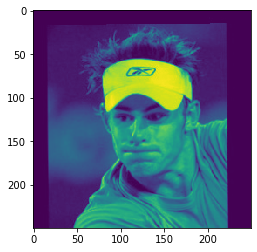

In [75]:
# 3. Find closest image in the original dataset to that cluster centroid
closest_to_centroid_0 = closest[0]
plt.imshow(closest_to_centroid_0)

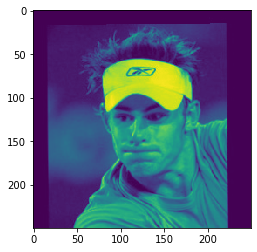

In [79]:
# 4. The closest image in the original dataset to my photo
my_cluster_closest_dist = np.sum((clusters[0].reshape(clusters[0].shape[0],250,250) - my_photo)**2)
my_cluster_closest_idx = np.argmin(my_cluster_closest_dist)
my_cluster_closest = clusters[0][my_cluster_closest_idx]
plt.imshow(my_cluster_closest.reshape(250,250))

## 3. PCA and Eigenfaces 

Begin by normalizing your data. Then, set aside 50% of the images as "test" data and using the remaining images as "training" data.


### 3.1. How many components?

Run principal component analysis using [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) from sklearn on the training dataset. Create a figure showing how the amount of variance explained by your components increases as you increase the number of components from 1 to 100. How many components are required to explain 75% of the variation in your original data?

In [ ]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split()

*Your observations here*

### 3.2. Eigenfaces

Extract the 10 first principal components (the "eigenfaces") and display them below.

In [ ]:
# Enter your code here

### 3.3. Projections, clustering and PCA
 - Project all of the training and test data into the 50-dimensional space defined by the first 50 principal components.
 - Apply k-means clustering, with k=20, to the 50-dimensional projections of the training data. 
 - Display a 4 x 5 grid of images that shows what each of the 20 centroids look like after the centroid is projected back into the original-image space.

In [ ]:
# Enter your code here

### 3.4. Recognition

Create a test set of 10 images using (i) 8 images randomly selected from the test data, (ii)  any other non-face image you can find that has the right dimensions, and (iii) an image of yourself. Create a 10 x 5 grid of images, with one row for each of these images, and 5 columns that contain: 
1. The original image. 
2. The reconstruction of that image after it is projected onto the 50-dimensional eigenface-space and then re-projected back into the original image space. 
3. Find the nearest centroid (from 3.3) to the image, and show the reconstruction of that nearest centroid. 
4. Find the image in the training data whose 50-dimensional representation is closest to that centroid, and show the reconstruction of that image.
5. Show the original training image that was selected in above (step 4 in this list)

In [ ]:
# Enter your code here

### 3.5. (Extra credit) Share your results
Post the following to bCourses for people in the class to see:
 - The photo of yourself
 - The cluster centroid from 2.4 that is closest to that image
 - The closest image in the dataset to that cluster centroid
 - The reconstruction of your image after it has been projected and reprojected (i.e., #2 in 3.4)
 - The nearest centroid to the projection (i.e., #3 in 3.4)
 - The closest training image to that centroid (i.e., #5 in 3.4)

### 3.6. (Extra extra credit) PCA Implementation

Implement PCA yourself, without using sklearn. How does the running time of your algorithm compare to the running time of the sklearn version?

In [ ]:
# Enter your code here

### 3.7. (Extra extra extra credit): k-Means++
- In 2.1 you implemented k-Means clustering with random initialization of the centroids. In this part implement the k-Means++ version of the algorithm that uses a "smarter" initialization of the centroids in order to achieve faster convergence. Compare the number of iterations it took k-Means in 2.3 to converge with random initialization to the number of iterations it takes k-Means++. Also compare the sum of squared errors that you obtain for both methods. Use for both k=20 clusters. The following link shows the paper that proposed k-Means++.
http://ilpubs.stanford.edu:8090/778/1/2006-13.pdf

*Your observations here*